# A dynamic programming model of incremental cue-based trait specialization through develepment.

The environment takes one of two states - E0 or E1 - and a single phenotypic specialization steps, Y0 or Y1, can be taken during each timestep through development for `T` timesteps. Fitness is conferred at the end of development, and optimal choices (e.g., whether to specialize towards E0 or E1) given imperfect cues (for either E0 or E1) are determined via stochastic dynamic programming (SDP). A simulation that employs the optimal rules generated by SDP is then used as a tool to visualize developmental trajectories for a population.


In [2]:
# Loading in libraries (Note: these libraries must first be installed)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from collections import Counter

### First, we specifiy the variables that will be used throughout.

In [19]:
T = 21                    # Number of developmental timesteps

fit_benefit_switch = 0    # Changes fitness benefit function: 0 is linear, 1 is convex, 2 is concave

PC1E1  = 0.6              # cue reliability; probabilities of receiving the 'right' cue
PC0E0  = 0.6

PC0E1 = 1 - PC1E1         # probability of receiving the wrong cue
PC1E0 = 1 - PC0E0

priorE0 = 0.5             # prior prob of E0 (set evolutionarily)
priorE1 = 1 - priorE0     # prior prob of E1 (set evolutionarily)

### Defining the shape of the fitness function
Controlled by `fit_benefit_switch` as described in initial parameter setting step.

Fitness benefit is any fitness gained through having phenotypic increments in 'right' direction.

In [20]:
def fit_benefit(postE0,postE1,y0,y1):
    
    if fit_benefit_switch == 0:
        # then linear function
        
        return(postE0 * y0 + postE1 * y1)
        
    elif fit_benefit_switch == 1:
        # then convex function
        
        beta = 0.1
        alpha = (T - 1)/(math.exp(beta * (T - 1)) - 1)
        return(postE0 * alpha * (math.exp(beta * y0) - 1) + postE1 * alpha * (math.exp(beta * y1) - 1))
    
    else:
        # then concave function
        
        beta = -0.1
        alpha = (T - 1)/(1 - math.exp(-beta * (T - 1)))
        return(postE0 * alpha * (1 - math.exp(-beta * y0)) + postE1 * alpha * (1 - math.exp(-beta * y1)))

### Originating the total space of possible cue sets
Creates a list of arrays (`cues`) where the index of each array in the list corresponds to the developmental timestep (e.g., first array in list is set of possible cues from first developmental timestep, `t`). Each `(t+1)`-by-2 array is the set of possible cues receieved by timestep `t`.

In [21]:
cues = []

for j in range(1,T):
    x0seq = np.arange(0,j+1)
    x1seq = np.arange(j,-1,-1)
    cues_stack = np.stack((x0seq, x1seq), axis=-1)
    cues.append(cues_stack)

### Calculating probability of receiving a particular cue set
Produces the following lists of arrays:

`cue_prob` <- the probability of receiving a particular cue set

`cue_probE0` <- the probability of receiving a particular cue set conditional on being in E0

`cue_probE1` <- the probability of receiving a particular cue set conditional on being in E1

`postE0` <- posterior probability that state of the world is E0 given a particular cue set

`postE1` <- posterior probability that state of the world is E1 given a particular cue set

In [22]:
cue_prob = []
cue_probE0 = []
cue_probE1 = []
postE0 = []
postE1 = []

for i in range(0,len(cues)):
    cue_prob_bystage = np.zeros(len(cues[i]))
    cue_probE1_bystage = np.zeros(len(cues[i]))
    cue_probE0_bystage = np.zeros(len(cues[i]))
    postE0_bystage = np.zeros(len(cues[i]))
    postE1_bystage = np.zeros(len(cues[i]))
    
    for j in range(0,len(cues[i])):
        # For these calculations, we use Bayes Equation and multiple by all the possible ways of arriving at a particular cue set.
        
        cue_probE0_bystage[j] = (math.factorial(cues[i][j][0] + cues[i][j][1])/(math.factorial(cues[i][j][0]) * math.factorial(cues[i][j][1]))) * PC0E0**cues[i][j][0] * PC1E0**cues[i][j][1]
        cue_probE1_bystage[j] = (math.factorial(cues[i][j][0] + cues[i][j][1])/(math.factorial(cues[i][j][0]) * math.factorial(cues[i][j][1]))) * PC1E1**cues[i][j][1] * PC0E1**cues[i][j][0]
        cue_prob_bystage[j] = cue_probE0_bystage[j] * priorE0 + cue_probE1_bystage[j] * priorE1
        
        postE0_bystage[j] = (cue_probE0_bystage[j] * priorE0)/(cue_probE0_bystage[j] * priorE0 + cue_probE1_bystage[j] * priorE1)
        postE1_bystage[j] = (cue_probE1_bystage[j] * priorE1)/(cue_probE0_bystage[j] * priorE0 + cue_probE1_bystage[j] * priorE1)
        
    cue_prob.append(cue_prob_bystage)  
    cue_probE0.append(cue_probE0_bystage)  
    cue_probE1.append(cue_probE1_bystage)
    postE0.append(postE0_bystage)
    postE1.append(postE1_bystage)

### Originating a list of a list of matrices that keep track of maximum expected fitness for each timestep, cue-set, and decision (y0, y1) combination.
For now, all entries are 0. Will be filled in in dynamic programming step.

In [23]:
expected_fit = []
mega_fit = []
opt_choice = []

for t in range(0,T-1):
    fit_list = []
    opt_list = []
    mega_fit_list = []
    for c in range(0,len(cues[t])):
        fit_array = []
        opt_array = []
        fit_array = np.zeros((len(cues[t]),len(cues[t])))
        opt_array = np.zeros((len(cues[t]),len(cues[t])))
        fit_list.append(fit_array)
        opt_list.append(opt_array)
    
    expected_fit.append(fit_list)
    opt_choice.append(opt_list)
    
    
    for c in range(0,len(cues[t]) + (len(cues[t]) - 1)):
        mega_fit_array = np.zeros((len(cues[t]),len(cues[t])))
        mega_fit_list.append(mega_fit_array)
        
    mega_fit.append(mega_fit_list)

### Filling in fitness values for all cue-set, y0, y1 combinations at time horizon, T from fitness function

In [24]:
postE0_term = []
postE1_term = []

for n in range(0,len(postE0[-1])):
    
    postE0_term.append(postE0[-1][n])
    postE1_term.append(postE1[-1][n])

    if n < (len(postE0[-1]) - 1):
        postE0_term.append(postE0[-2][n])
        postE1_term.append(postE1[-2][n])
    
    
    for y0 in range(0,T):
        for y1 in range(0,T - y0):
            
            expected_fit[T-2][n][y0,y1] = fit_benefit(postE0[-1][n],postE1[-1][n],y0,y1)
            
                       
for n in range(0,len(mega_fit[T-2])):
    
    for y0 in range(0,T):
        for y1 in range(0,T - y0):
            
            mega_fit[T-2][n][y0,y1] = fit_benefit(postE0_term[n],postE1_term[n],y0,y1) 

### Dynamic programming step - working backwards from time horizon to calculate max expected fitness and optimal decisions

Working backward from the terminal fitness function (where fitness is definted), we end up with our `expected_fit` list of matrices completely filled in with expected fitness values for all timesteps and trait combinations

In [25]:
for n in range(0,T-2):
    t = T - 3 - n
    max_fit_list = []
    opt_move_list = []

    for m in range(0,len(mega_fit[t])):
        max_fit_array = []
        max_fit_array = np.zeros((len(cues[t]),len(cues[t])))
        opt_move_array = np.zeros((len(cues[t]),len(cues[t])))
        
        for y0 in range(0,t+2):
            y1 = np.arange(0,t+2-y0)
            
            for yy in range(0,len(y1)):
                
                F0 = []
                F1 = []
                FW = []
                
                F0 = mega_fit[t+1][m+1][y0+1, y1[yy]]
                F1 = mega_fit[t+1][m+1][y0, y1[yy] + 1]
                FW = mega_fit[t+1][m+1][y0, y1[yy]]

                possible_fit = np.array((F0,F1,FW))
                mega_fit[t][m][y0,y1[yy]] = max(possible_fit)
                
    expected_fit[t] = mega_fit[t][::2]

### Now we run a simulation of `num_sim` individuals making optimal choices
Produces the following matrices:
`estimates` <- a `num_sim`-by-timestep matrix with all probability estimates througout development for `num_sim` individuals

`choices` <- a `num_sim`-by-timestep matrix showing the sequences of choices individuals made. `y0_log` and `y1_log` are versions of this, recording the timestep when increments y0 or y1 were made, respectively.

`cues_received` <- a `num_sim`-by-timestep matrix showing the sequences of cues individuals received

In [35]:
num_sim = 500


estimates = np.zeros((num_sim, len(cues) + 1))
estimates[:,0] = priorE1
choices = np.zeros((num_sim, len(cues) + 1))
env_states = []
y0_log = []
y1_log = []


cues_received = np.zeros((num_sim,len(cues)))

for i in range(0,num_sim):
    draw = np.random.binomial(1, priorE1, 1)  # A binomial draw with prob, priorE1, of the environmental state being E1
    env_states.append(draw)
    
    y0 = np.int64(0)
    y1 = np.int64(0)
    y0_log_i = []
    y1_log_i = []
    y0_log_i.append(0)
    y1_log_i.append(0)
    
    if float(draw) == 0:              
        # if the environment is E0, perform T-1 binomial draws of cues with prob (of recieving cue 1) of PC1E0.
        
        cues_received[i,] = np.random.binomial(1, PC1E0, len(cues))
    else:
        cues_received[i,] = np.random.binomial(1, PC1E1, len(cues))
    
    
    for t in range(0,len(cues)):
        x1 = np.int64(sum(cues_received[i,0:t+1]))
        x0 = t + 1 - x1
        cues_added = np.array((x0,x1))
        
        estimates[i,t+1] = postE1[t][x0]
        
        go0 = expected_fit[t][x0][y0 + 1, y1]
        go1 = expected_fit[t][x0][y0, y1 + 1]
        gw  = expected_fit[t][x0][y0, y1]
       
        best_choice = max(go0, go1, gw)
        possible_fit = np.array((go0,go1,gw))
        
        max_index = np.where(possible_fit == max(possible_fit))
        max_index = max_index[0]
                         
        if len(max_index) > 1:
            # if multiple decisions have the same payoff, randomly choose among them
            
            flip = np.random.randint(0,np.int64(len(max_index)))
            chosen = max_index[flip]
        else:
            chosen = max_index
                                  
        if chosen == 0:
            choices[i,t+1] = choices[i,t] - 1
            y0 = y0 + 1                    
        elif chosen == 1:
            choices[i,t+1] = choices[i,t] + 1
            y1 = y1 + 1                       
        else:
            choices[i,t+1] = choices[i,t] 
        
        y0_log_i.append(y0)
        y1_log_i.append(y1)
        
    y0_log.append(y0_log_i)
    y1_log.append(y1_log_i)
        
                                

### Graphing developmental trajectories in `num_sim` individuals.

The following plot visualizes the degree of specialization toward a particular environment's optimum when that particular environment is the true state of the environment. The color of the lines represent the posterior estimates at each point through development. There is some transparency to lines.

([<matplotlib.axis.YTick at 0x7faa9f0ca610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

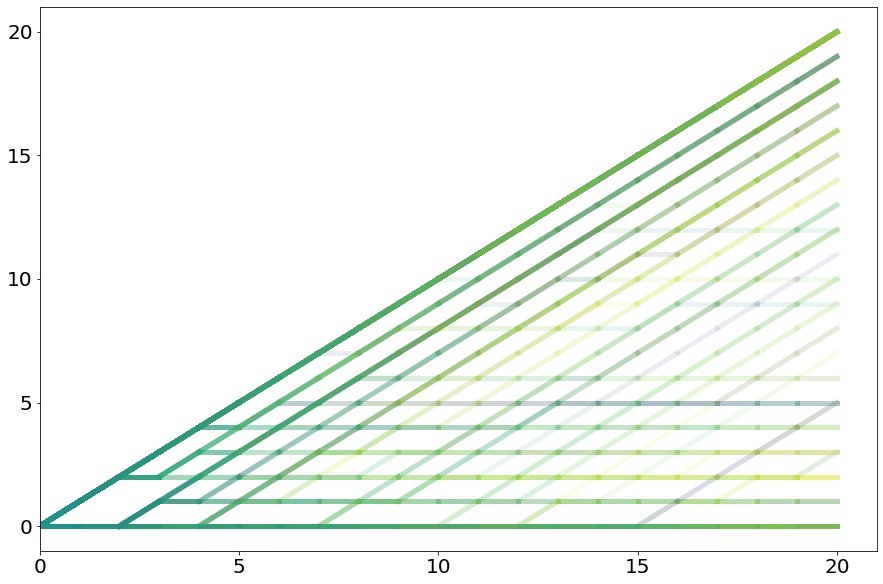

In [36]:
color_map = cm.get_cmap('viridis', 100)

plt.figure(figsize=(15,10))
plt.xlabel('', size = 20)
plt.ylabel('', size = 20)
plt.xlim(0,T)
plt.ylim(-1,(T))

choicesE0 = choices[np.where(env_states)[0],:]
estimatesE0 = estimates[np.where(env_states)[0],:]

for i in range(0, len(choicesE0)):
    for j in range(0, len(cues)):
        plt.plot([j,j+1],[unichoice[i][j],unichoice[i][j+1]],c=color_map(np.int64((100*estimatesE0[i,j]))),alpha=0.1, linewidth = 5)
        
        
       
plt.xticks([0, 5, 10, 15, 20], fontsize = 20)
plt.yticks([0, 5, 10, 15, 20],fontsize = 20) 

### Graphing developmental trajectories in y0-y1 trait space. 

The color here represents the timestep. The thickness of line corresponds to the proportion of the population that exhibits a particular trait transition. The black line is the average value in y0/y1 trait space through time. 

In [28]:
y0_log_E0 = np.array(y0_log)[np.where(np.array(env_states) == 0)[0]]
y1_log_E0 = np.array(y1_log)[np.where(np.array(env_states) == 0)[0]]

point_log = []
point_log_dict = []

for i in range(0,len(y0_log_E0)):
    
    for j in range(0, len(y0_log_E0[i])-1):
        
        x1 = y0_log_E0[i][j]
        x2 = y0_log_E0[i][j+1]
        y1 = y1_log_E0[i][j]
        y2 = y1_log_E0[i][j+1]
        
        point_log.append([x1,x2,y1,y2])
        point_log_dict.append(str([x1,x2,y1,y2]).strip('[]'))

In [29]:
dictlist = Counter(point_log_dict)        

listie_keys = list(dictlist.keys())
listie_freq = list(dictlist.values())

unique_lines = []

for i in range(0, len(listie_keys)):
    points_str = listie_keys[i].split(',')
    x1 = np.int64(points_str[0])
    x2 = np.int64(points_str[1])
    y1 = np.int64(points_str[2])
    y2 = np.int64(points_str[3])
    
    unique_lines.append([x1,x2,y1,y2])

y0_X = np.concatenate(y0_log).ravel()
y1_Y = np.concatenate(y1_log).ravel()

In [30]:
avg_y0 = []
avg_y1 = []

for i in range(0, len(y0_log_E0[0])):
    eyes_y0 = []
    eyes_y1 = []
    
    for j in range(0, len(y0_log_E0)):
        eyes_y0.append(y0_log_E0[j][i])
        eyes_y1.append(y1_log_E0[j][i])
        
    avg_y0.append(np.mean(eyes_y0))
    avg_y1.append(np.mean(eyes_y1))

([<matplotlib.axis.YTick at 0x7fab3f295fa0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

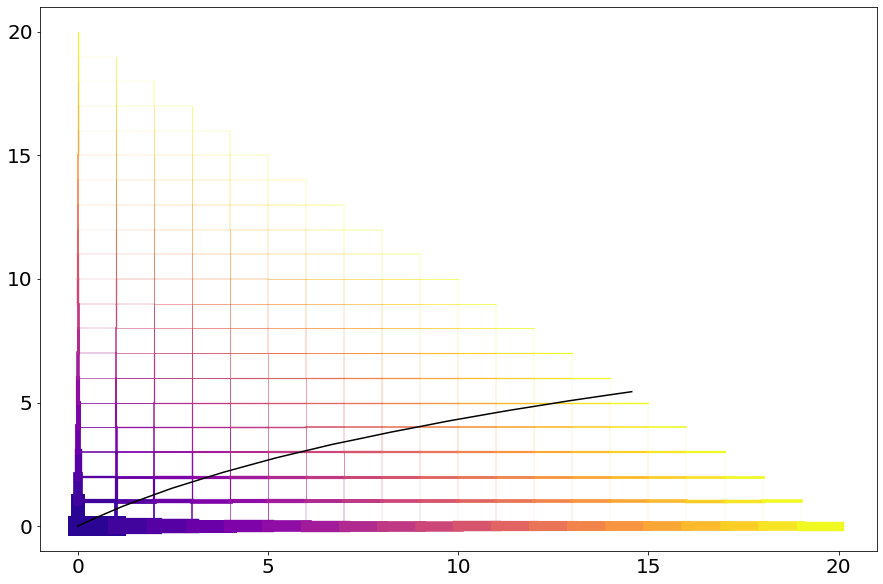

In [31]:
color_map = cm.get_cmap('plasma', T)

merx = max(listie_freq)
divider = merx / 20

plt.figure(figsize=(15,10))
plt.xlabel('', size = 20)
plt.ylabel('', size = 20)
plt.xlim(-1,T)
plt.ylim(-1,T)

for i in range(0, len(unique_lines)):
    plt.plot([unique_lines[i][0],unique_lines[i][1]],[unique_lines[i][2],unique_lines[i][3]],c=color_map(unique_lines[i][1]+unique_lines[i][3],), linewidth = listie_freq[i]/divider)
    
plt.plot(avg_y0,avg_y1, c = 'black')
plt.xticks([0, 5, 10, 15, 20], fontsize = 20)
plt.yticks([0, 5, 10, 15, 20],fontsize = 20)

### Graphing the 'trait space phase diagram'. 

This graph represents the 'push' towards E0 or E1 given a particular y0/y1 trait combination. Note that `num_sim` must be large for this plot to be accurate. 

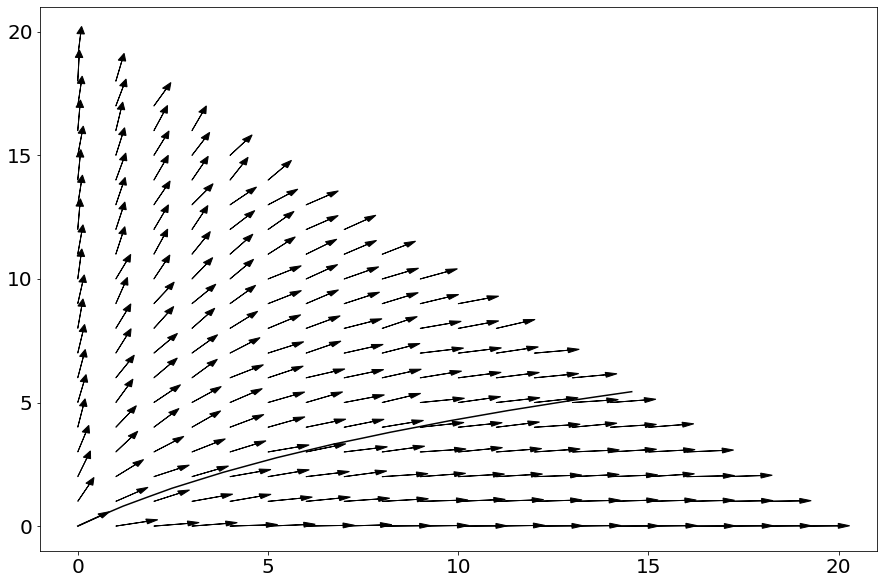

In [32]:
color_map = cm.get_cmap('viridis', max(listie_freq))

merx = max(listie_freq)
divider = merx / 20

plt.figure(figsize=(15,10))
plt.xlabel('', size = 20)
plt.ylabel('', size = 20)
plt.xlim(-1,T)
plt.ylim(-1,T)

plt.plot(avg_y0,avg_y1, c = 'black')
plt.xticks([0, 5, 10, 15, 20], fontsize = 20)
plt.yticks([0, 5, 10, 15, 20],fontsize = 20)
# _______________________________________________

y0_max_range = np.array(range(T-1, -1, -1))
freq_cat_big = []

for n in range(0, len(y0_max_range)):
    y0_max = y0_max_range[n]
    y1_max = T - 1 - y0_max
    
    for y0_count in range(0, y0_max):
        y0 = y0_count
        y1 = y1_max
        
        freq_catalogue = []
        unique_lines_to_plot = []
        for i in range(0, len(unique_lines)):
            
            if unique_lines[i][0] == y0 and unique_lines[i][2] == y1:
                unique_lines_to_plot.append(unique_lines[i])
                freq_catalogue.append(listie_freq[i])
        
        widths = []
        widths_scaled = []

        freq_catalogue = np.array(freq_catalogue)
        max_width = 1
        widths = freq_catalogue/sum(freq_catalogue)
        widths_scaled = freq_catalogue/sum(freq_catalogue) * max_width
        alpha_max = max(listie_freq) * 2
        col = sum(freq_catalogue)
        alph = (sum(freq_catalogue)/alpha_max) * 2
        freq_cat_big.append(widths)
        
        x_0 = y0
        y_0 = y1
        
        if len(widths) > 1:
            if unique_lines_to_plot[0][1] > unique_lines_to_plot[0][0]:
                x_len = widths[0]
                y_len = widths[1]
            else:
                x_len = widths[1]
                y_len = widths[0]
        
        else:
            if unique_lines_to_plot == []:
                print('')
            elif unique_lines_to_plot[0][1] > unique_lines_to_plot[0][0]:
                x_len = 1
                y_len = 0
            else:
                x_len = 0
                y_len = 1
        
        plt.arrow(x_0, y_0, x_len, y_len, head_width = 0.2, alpha = 1, color = 'black')